In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil

from IPython.display import display, Image
from EAZY_fun import *
from scipy import interpolate
from scipy import integrate
from astropy.io import ascii
from astropy.wcs import WCS
from matplotlib.ticker import AutoMinorLocator
from synphot import SourceSpectrum, etau_madau
from synphot.models import ConstFlux1D
from synphot.models import Empirical1D
import glob



The best


In [2]:
way2 = 'goodss_3dhst.v4.1.cat'
way  = '/home/tuberozova/my_eazy/tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'

In [3]:
# Загружаем все модельные спектры и главный каталог
list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(way2, skip_header=2)

In [4]:
# Номера столбцов потоков в главном каталоге
#flux_cat = [9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,\
#           78,81,84,87,89,91,93,95,97,99,101,103,105,107,109,111,113]
fl1 = np.linspace(9, 87, 27)
fl2 = np.linspace(89, 113, 13)
num_fc = np.hstack((fl1, fl2))


# Номера столбцов ошибок в главном каталоге
#error_flux_cat = [10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,\
 #                 73,76,79,82,85,88,90,92,94,96,98,100,102,104,106,108,110,112,114]
efl1 = np.linspace(10, 88, 27)
efl2 = np.linspace(90, 114, 13)
num_efc = np.hstack((efl1, efl2))


# Центральные длины волн фильтров
lambd = np.array(([1.5396, 0.3637, 0.3750, 0.4318, 0.4563, 0.5396, 0.5921, 0.5919, 0.6443, 0.6517,\
                   0.7693, 0.7838, 0.8057, 0.9036, 0.9033, 1.2471, 1.2356, 1.2530, \
                   1.3924, 1.6496, 2.1574, 2.1667, 3.5569, 4.5020, 5.7450, 7.9158, 0.4260, 0.4443, 0.5061, 0.5259,\
                   0.5495, 0.5763,  0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966, 0.8565]))


In [5]:
# Функция смещения длины волны и сдвига амплитуды потока
def func_1(z, n, x, y):
    l_mod  = (1+z)*x
    mod_flux = n*y
    return l_mod, mod_flux

In [6]:
# Номер обьекта
id = 28684

# Космологические константы
Omega_M = 0.2726             # Плотность материи
Omega_K =  0.0               # Плотность кривизны
Omega_L = 0.7274             # Плотность тёмной энергии
h = 0.704

# Для справки
c = 2.9927e10
pi = 3.14159265


# Сборник дополнительных функций расстояний
E   = lambda x: 1/np.sqrt(Omega_M*np.power(1+x,3)+Omega_L+Omega_K*np.power(1+x,2))
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]                                     # В сантиметрах
D_m = lambda x: D_c(x)
D_A = lambda x: D_m(x)/(1+x)
D_L = lambda x: np.power(1+x, 2) * D_A(x)

In [7]:
# Функция, которая учитывает поглощение и различные переводы величин. Возвращает значение смещенного модельного спектра 
def chi(z, n, lcii, x, y):

    # Находим template соответствующий нашим z и n
    l_obs2, mod_flux2 = func_1(z, n, x, y)


    # Считаем, что поток в template записан с z = 25, тогда в эрг/c
    mod_flux2 = mod_flux2 * 10**(-0.4*(25+48.6))


    # Пересчитаем поток исходя из его красного смещения
    mod_flux3 =np.ones(len(mod_flux2))
    mod_flux3 = [(1+z)*np.array(mod_flux2[i])/( 4*pi*np.power(D_L(z),2) ) for i in range(len(mod_flux2))]

    #Пересчитаем поток в наноянски из эрг/сек
    mod_flux3 = np.array(mod_flux3) * 10**32

    # Сортировка
    mod_flux3 = mod_flux3[np.argsort(l_obs2)]


    # Приводим к хорошему типу
    mod_flux3 = np.array(mod_flux3)
    moh = np.zeros(len(mod_flux3))
    moh = [mod_flux3[i] for i in range(len(mod_flux3))]
    moh = np.array(moh)
    
    lcii = np.array(lcii)
    
    # Сортировка
    moh = moh[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]
    lcii = lcii[np.argsort(lcii)]

    # Создадим спектр по точкам
    sp2 = SourceSpectrum(Empirical1D, points=l_obs2, lookup_table=moh)

    # Добавим поглощение для обьектов с большим красным смещением
    extcurve = etau_madau(l_obs2, z)
    sp_ext = sp2 * extcurve

    
    # Сравним два спектра, с поглощением и без
    plt.plot(l_obs2, sp2(l_obs2), 'blue', l_obs2, sp_ext(l_obs2), 'r', lw =2)
    plt.scatter(l_obs2, moh, s = 25, color='black')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux (nJy)')
    plt.legend(['Original', 'Extincted'], loc='upper left', fontsize=15)
    plt.xlim(0, 10000)
    plt.ylim(0, 200)
    plt.show()
    print('max', np.max(l_obs2))
    

    # Интерполяция, она уже не нужна по сути
    func = np.interp(lcii, l_obs2, moh)


    # return fit
    # return  func
    return sp_ext(lcii)

In [8]:
# Спектр с каталога hst
flux_c = []
erflu_c = []
filt = []

for i in range(len(main_cat[0, :])):
    for j in range(len(num_fc)):
        if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
            flux_c.append(main_cat[id - 1, i])
            erflu_c.append(main_cat[id - 1, int(num_efc[j])])
            filt.append(j)

# Переведем длину волны в ангстремы
lci = lambd[filt] * 10 ** 4

# Переведем поток в наноянски
flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]

# Приводим к хорошему типу
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

In [9]:
# Сортировка
flux_c = flux_c[np.argsort(lci)]
erflu_c = erflu_c[np.argsort(lci)]
lci = lci[np.argsort(lci)]

# Данные с template
ntemplate = 0
x = np.genfromtxt(list[ntemplate])[:, 0]
y = np.genfromtxt(list[ntemplate])[:, 1]


<IPython.core.display.Javascript object>


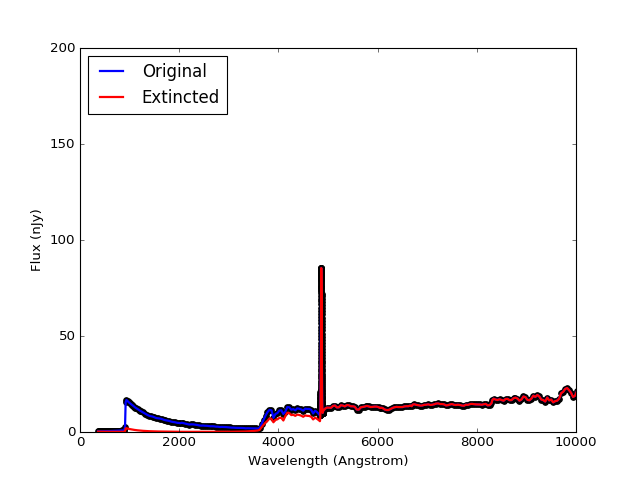

max 6400000.0
(33,) <class 'numpy.float64'>
PHOTLAM


In [16]:
# Сколько хотим точек для z и n
t = 11


z_list = np.linspace(0.1,9,t)
n_list = np.linspace(1.2*10**58,2.3*10**58,t)

fib = chi(3, 1.6*10**58, lci, x, y)
print(np.shape(fib), type(fib.value[1]))
# У меня подозрения вызывают эти единицы. Поток я посылаю в наноянски, а здесь он выдает вообще нечто другое.
# Влияет это как то на точность или нет?
print(fib.unit) 

In [ ]:
L = np.ones((t,t))

for i in range (len(n_list)):
    for j in range (len(z_list)):
        fitz = chi(z_list[j], n_list[i], lci, x, y)
        sum = 0
        for k in range(len(lci)):
            sum+=(flux_c[k] - fitz.value[k])**2/(erflu_c[k]**2)
        L[i,j] = sum


In [ ]:
plt.imshow(np.log10(L), cmap = 'gray', vmin = np.min(np.log10(L.flatten())), vmax = np.max(np.log10(L.flatten())), extent=[0, t, 0, t])
plt.show()


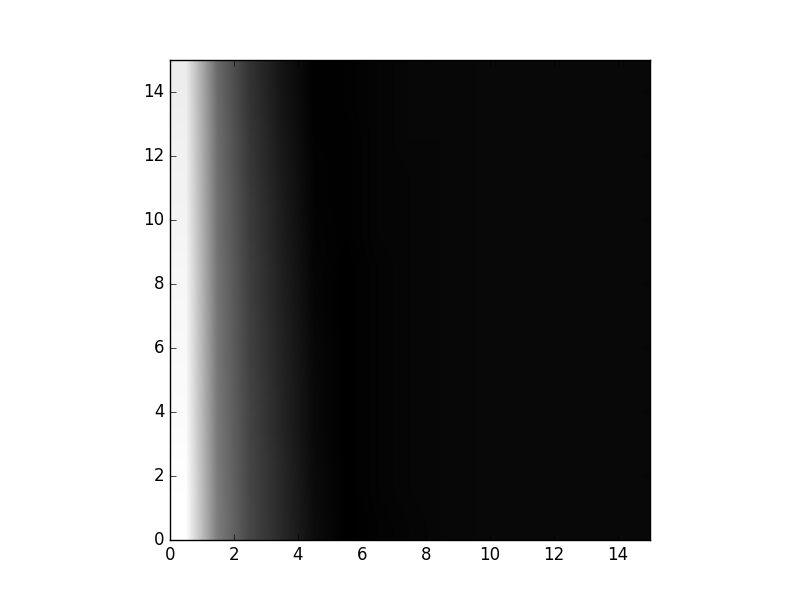

In [10]:
# Юпитер не справляется, поэтому я загружу картинку.
im = Image('Chi_32.png')
display(im)


